#  SQL X Manchester United: A tale of two seasons.
### 2008/2009 and 2010/2011 Premier League campaigns
The club's performance in both seasons was exceptional- winning the league in each of them. The objective of this report is to manipulate the available data and try to find similarities and differences in Manchester United's(MU) performance in both these seasons.

In [1]:
import sqlalchemy
#!pip install ipython-sql
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.style as style
import matplotlib.pyplot as plt

### Connecting to the database
For this project, I am using the European Soccer Database.
After creating the connection, ipython-sql is activated.
This enables the use of magic sql for executing SQL commands directly.

In [2]:
sqlalchemy.create_engine('sqlite:///EU_fut.sqlite')
%load_ext sql
%sql sqlite:///EU_fut.sqlite

####  team_api_id for MU
Each team in the Team table is assigned a team_api_id. The query below retrieves the entire row for Manchester United.
We will be using the team_api_id value in the following cells.

In [5]:
# id = 10260
%sql SELECT * FROM Team WHERE team_long_name = 'Manchester United';


 * sqlite:///EU_fut.sqlite
Done.


id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
3457,10260,11,Manchester United,MUN


###  Match table overview
The Match table contains the data for all the matches included in the database. Most of the useful information is contained within the first 11 columns. 
**id**: unique identifier for each match  
**league_id and country_id**: foreign keys for League and Country table respectively   
**home_team_api_id and away_team_api_id**: foreign keys for Team table. Team table contains information of all teams included in the database( name, short_name, etc.,). The api_id's will be used to retrieve names of teams for each match  
**B365 and Ladbrokes**: Data from multiple sports betting platforms is also included in the table, but we will only use data from B365 and LB. The decimal odds for home team win, away team win, and draw are provided for all matches from top European leagues. These 'odds' are determined by the bookies expectations and the public opinion about a certain event; in this case football matches.

In [10]:
%sql SELECT * FROM Match LIMIT 5;

 * sqlite:///EU_fut.sqlite
Done.


id,country_id,name
1,1,Belgium Jupiler League
1729,1729,England Premier League
4769,4769,France Ligue 1
7809,7809,Germany 1. Bundesliga
10257,10257,Italy Serie A
13274,13274,Netherlands Eredivisie
15722,15722,Poland Ekstraklasa
17642,17642,Portugal Liga ZON Sagres
19694,19694,Scotland Premier League
21518,21518,Spain LIGA BBVA


## Manchester United's record.
#### VIEW
In the cell below I have created a view to store the results of Manchester United's all 76 league games for two seasons( 38 each). VIEWs are stored as SQL statements in the database schema, and do not exist physically like tables. Storing the output as a view will be beneficial, because the query result/ Table will be used frequently, for further analyses.

### Retrieving the names of home and away teams.
We can get the name of a team from the Team table but the information for each match is stored in the Match table. Data is required from both tables so an INNER JOIN will be employed. For home_team, the home_team_api_id will be mapped to team_api_id from the Team table. For the away team, away_team_api_id will be used for joining. This task requires the use of subqueries.
#### CTE
Instead of using multiple subqueries, we can use common table expressions. A CTE is a temporary named result set that can be referenced in the main query. Using CTEs improves organization and accessability of queries.

### The result column.
The Match table contains columns for home and away goals scored in each match. Using this data I have created a column to store the outcome of each match from ManUtd's perspective( e.g., Manu_win). Employing CASE statements makes this task fairly simple. 

### Filtering 
A WHERE clause is used to filter for games played during the 2008/2009 and 2010/2011 seasons which included Manchester United.


In [74]:
%%sql 
CREATE VIEW manu_results AS 

/*Using CTE to select the name of the home team for each match*/
WITH home_cte AS (SELECT team_long_name AS home_team, home_team_api_id, Match.id, home_team_goal, season, stage,
B365H, B365D, LBH, LBD FROM Match INNER JOIN Team ON Match.home_team_api_id = Team.team_api_id),

/*Using CTE to select the name of the away team for each match*/
away_cte AS (SELECT team_long_name AS away_team, away_team_api_id, Match.id, away_team_goal,
B365A, LBA FROM Match INNER JOIN Team ON Match.away_team_api_id = Team.team_api_id)

SELECT stage, season, home_team, home_team_goal, away_team, away_team_goal, ABS(home_team_goal - away_team_goal) AS diff,

/*conditional statements to output the result of each match, from Manchester United's perspective */ 
CASE WHEN (home_team_goal > away_team_goal AND home_team_api_id = 10260)
OR (home_team_goal < away_team_goal AND away_team_api_id = 10260) THEN 'Manu_win'

WHEN (home_team_goal < away_team_goal AND home_team_api_id = 10260)
OR (home_team_goal > away_team_goal AND away_team_api_id = 10260) THEN 'Manu_loss'
ELSE  'Draw' END AS Result,

/* Betting information(Decimal odds) from BET365 and Ladbrokes for Manchester United''s games. */
B365H, B365A, B365D, LBH, LBA, LBD

/* Joining the two tables using match id( primary key in Match table). */
FROM home_cte INNER JOIN away_cte USING(id)

WHERE (home_team_api_id = 10260 OR away_team_api_id = 10260) AND season IN ('2008/2009', '2010/2011')
ORDER BY season, stage;

 * sqlite:///EU_fut.sqlite
Done.


[]

## Performance indicators
The VIEW created in the above cell stores all the data we need to calculate any statistical metric required for analyzing performance. 
### Total points
In a league system, racking up points is the be-all and end-all for any team. 
Lets start by calculating the total number of points Manchester United managed in each season.

First we create a CTE with a new column named points which stores the equivalent numeric value for each type of result(e.g: win = 3 points, loss = 0 points). Then, in the main query, select the sum of this points column and group the data for each season.

In [8]:
%%sql 
WITH points_cte AS (SELECT season, CASE WHEN Result = 'Manu_win' THEN 3 
                    WHEN Result = 'Manu_loss' THEN 0 
                    ELSE 1 END AS points FROM manu_results) 
SELECT season, SUM(points) AS total_points FROM points_cte GROUP BY season;


 * sqlite:///EU_fut.sqlite
Done.


season,total_points
2008/2009,90
2010/2011,80


## Wins, Losses and Draws
This one's a bit tricky; we need to aggregate data based on conditions. This can be done by enclosing the CASE statement within the aggregate function. Note that aliasing is done outside the agg. function. 


In [12]:
%%sql SELECT season,
    COUNT(CASE WHEN home_team = 'Manchester United' AND result = 'Manu_win' THEN stage END) AS home_wins,
    COUNT(CASE WHEN away_team = 'Manchester United' AND result = 'Manu_win' THEN stage END) AS away_wins,
    COUNT(CASE WHEN home_team = 'Manchester United' AND result = 'Manu_loss' THEN stage END) AS home_losses,
    COUNT(CASE WHEN away_team = 'Manchester United' AND result = 'Manu_loss' THEN stage END) AS away_losses,
    COUNT(CASE WHEN result='Draw' THEN stage END) AS draws
    FROM manu_results GROUP BY season;


 * sqlite:///EU_fut.sqlite
Done.
Returning data to local variable result_set


### Attack, attack, attack
An overview of Manchester United's offensive performance. 

#### Total and average number of goals scored in home and away games. 
Same technique- using conditional statements inside aggregate functions- is used.

In [7]:
%%sql SELECT season, SUM(CASE WHEN home_team = 'Manchester United' THEN home_team_goal END) AS total_goals_home,
    SUM(CASE WHEN away_team = 'Manchester United' THEN away_team_goal END) AS total_goals_away, 
    ROUND(AVG(CASE WHEN home_team = 'Manchester United' THEN home_team_goal END),1) AS avg_hgoals,
    ROUND(AVG(CASE WHEN away_team = 'Manchester United' THEN away_team_goal END),1) AS avg_awgoals
    FROM manu_results GROUP BY season;    

 * sqlite:///EU_fut.sqlite
Done.


season,total_goals_home,total_goals_away,avg_hgoals,avg_awgoals
2008/2009,43,25,2.3,1.3
2010/2011,49,29,2.6,1.5


#### Distrbution of goals scored over the course of the season

In [3]:
%%sql goal_dist << 
SELECT stage, season, home_team_goal AS goals_scored
FROM manu_results WHERE home_team = 'Manchester United'
UNION
SELECT stage, season, away_team_goal FROM manu_results
WHERE away_team = 'Manchester United'
ORDER BY season, stage;

 * sqlite:///EU_fut.sqlite
Done.
(sqlite3.OperationalError) near "goal_dist": syntax error
[SQL: goal_dist]
(Background on this error at: https://sqlalche.me/e/14/e3q8)


### Remember: "Attack wins you games, Defence wins you titles".
Well thats what Sir Alex said. So, the analysis won't be complete, unless we find out which team had a better defence.
Calculating  and obtaining the number of cleansheets, goals conceded per game and number of goals conceded in home and away games would provide us with some insights into this matter.

In [5]:
%%sql SELECT season, COUNT(CASE WHEN (home_team = 'Manchester United' AND away_team_goal = 0)
            OR (away_team = 'Manchester United' AND home_team_goal = 0) THEN stage END) AS cleansheets,
    SUM(CASE WHEN home_team = 'Manchester United' THEN away_team_goal END) AS gconceded_home,
    SUM(CASE WHEN away_team = 'Manchester United' THEN home_team_goal END) AS gconceded_away,
    ROUND(AVG(CASE WHEN home_team = 'Manchester United' THEN away_team_goal END),1) AS avg_gconceded_home,
    ROUND(AVG(CASE WHEN away_team = 'Manchester United' THEN home_team_goal END),1) AS avg_gconceded_away
            
    FROM manu_results
    GROUP BY season;

 * sqlite:///EU_fut.sqlite
Done.


season,cleansheets,gconceded_home,gconceded_away,avg_gconceded_home,avg_gconceded_away
2008/2009,24,13,11,0.7,0.6
2010/2011,15,12,25,0.6,1.3


### Visualizing Insights.
#### Steps:
##### 1) Select all of the stats 


In [4]:
%%sql result_set << 
    SELECT season,
    COUNT(CASE WHEN home_team = 'Manchester United' AND result = 'Manu_win' THEN stage END) AS home_wins,
    COUNT(CASE WHEN away_team = 'Manchester United' AND result = 'Manu_win' THEN stage END) AS away_wins,
    COUNT(CASE WHEN home_team = 'Manchester United' AND result = 'Manu_loss' THEN stage END) AS home_losses,
    COUNT(CASE WHEN away_team = 'Manchester United' AND result = 'Manu_loss' THEN stage END) AS away_losses,
    COUNT(CASE WHEN result='Draw' THEN stage END) AS draws,
    SUM(CASE WHEN home_team = 'Manchester United' THEN home_team_goal END) AS total_goals_home,
    SUM(CASE WHEN away_team = 'Manchester United' THEN away_team_goal END) AS total_goals_away, 
    ROUND(AVG(CASE WHEN home_team = 'Manchester United' THEN home_team_goal END),1) AS avg_hgoals,
    ROUND(AVG(CASE WHEN away_team = 'Manchester United' THEN away_team_goal END),1) AS avg_awgoals,
    COUNT(CASE WHEN (home_team = 'Manchester United' AND away_team_goal = 0)
            OR (away_team = 'Manchester United' AND home_team_goal = 0) THEN stage END) AS cleansheets,
    SUM(CASE WHEN home_team = 'Manchester United' THEN away_team_goal END) AS gconceded_home,
    SUM(CASE WHEN away_team = 'Manchester United' THEN home_team_goal END) AS gconceded_away,
    ROUND(AVG(CASE WHEN home_team = 'Manchester United' THEN away_team_goal END),1) AS avg_gconceded_home,
    ROUND(AVG(CASE WHEN away_team = 'Manchester United' THEN home_team_goal END),1) AS avg_gconceded_away
            
    FROM manu_results
    GROUP BY season;

 * sqlite:///EU_fut.sqlite
Done.
Returning data to local variable result_set


##### 2) store them as a pandas DataFrame object, then Unpivot the dataframe to create multiple subsets.

In [51]:
df = result_set.DataFrame()
match_outcomes = df.melt(id_vars=['season'],value_vars=['home_wins','away_wins','home_losses','away_losses','draws'], var_name = 'perf_indicators')
goals_total = df.melt(id_vars=['season'],value_vars=['total_goals_home','total_goals_away','gconceded_home','gconceded_away', 'cleansheets'], var_name = 'perf_indicators')
goals_avg = df.melt(id_vars=['season'],value_vars=['avg_hgoals','avg_awgoals','avg_gconceded_home','avg_gconceded_away'], var_name = 'perf_indicators')
df_gdist = goal_dist.DataFrame()


##### 3) Plot

<AxesSubplot:xlabel='perf_indicators', ylabel='value'>

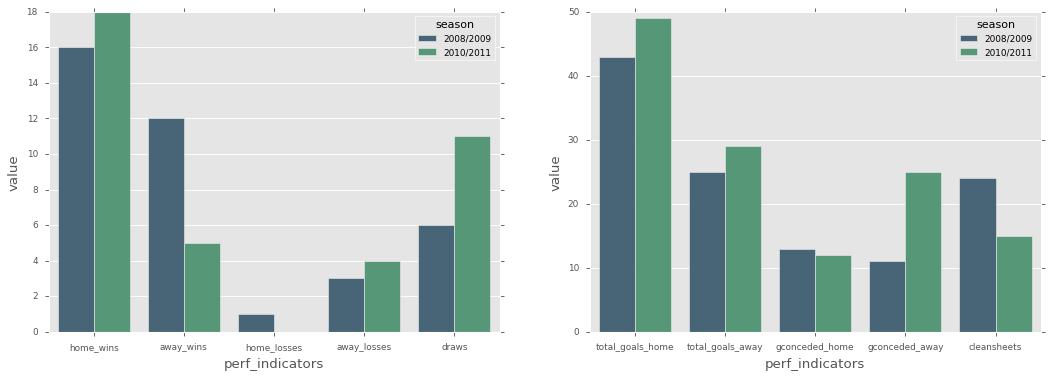

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
style.use('ggplot')
sns.barplot(data=match_outcomes, x = 'perf_indicators', y='value', hue='season',palette= ('viridis'), saturation=0.5, ax=axes[0])
sns.barplot(data=goals_total, x = 'perf_indicators', y='value', hue='season',palette= ('viridis'), saturation=0.5, ax=axes[1])

<AxesSubplot:xlabel='stage', ylabel='goals_scored'>

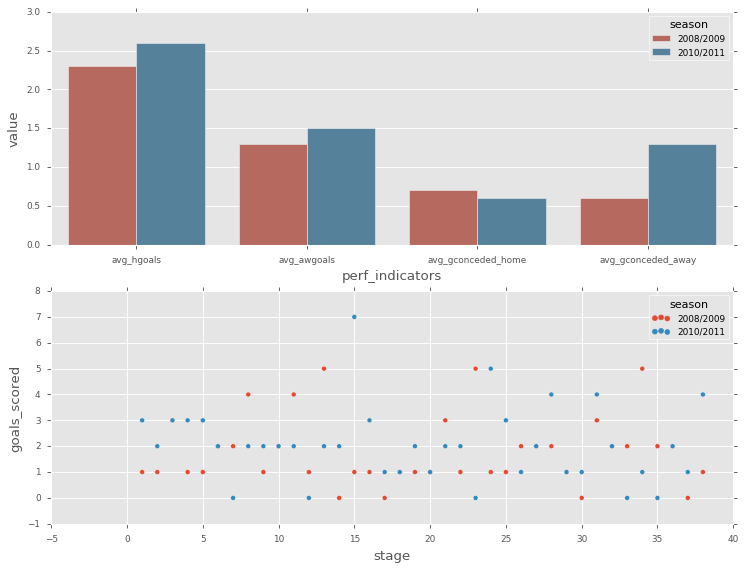

In [60]:
fig, axes = plt.subplots(2, 1, figsize=(11,8))
sns.barplot(data=goals_avg, x = 'perf_indicators', y='value', hue='season', saturation=0.5, ax=axes[0])
sns.scatterplot(data=df_gdist, x='stage', hue='season', y='goals_scored',ax=axes[1])

## Final verdict:
1) Although the points tally for the 2008/2009 season is higher, Manchester United won the league by a bigger margin in 2011.

2) The MU team was extremely dominant in the home games during the 2010/2011 season, winning 18 out of their 19 home games and drawing one. But their away record was not that amazing- 5 wins, 4 losses and 10 draws.On the other hand, the home and away results were much more balanced in the 08/09 season. 

3) The 10/11 team was slightly better going forward than the 08/09 team, as suggested by our results. 

4) The 08/09 team was incredibly solid at the back, conceding only 24 goals in the entire campaign and racking up 24 cleansheets. And what's even more remarkable is the fact that the team  was equally brilliant, defensively, in home and away games.That team set very high standards in the defending department, standards which the 10/11 MU team fell short off. They conceded far more goals(37) and managed far fewer cleansheets(15).

### What do the bookies say?
The analysis shows that Manchester United's performance in the 2008/2009 season was better. Now let's see what the bookies thought of their prowess in each season.

#### Odds against the top teams.

In [4]:
%%sql SELECT season, ROUND(AVG(CASE WHEN home_team='Manchester United' THEN B365H END),2) AS mu_odds,
    ROUND(AVG(CASE WHEN away_team='Manchester United' THEN B365H END),2) AS rivals_odds 
    FROM manu_results WHERE home_team IN ('Chelsea','Arsenal','Everton','Liverpool','Manchester City','Tottenham')
    OR
    away_team IN ('Chelsea','Arsenal','Everton','Liverpool','Manchester City','Tottenham')
    GROUP BY season;

    

 * sqlite:///EU_fut.sqlite
Done.


season,mu_odds,rivals_odds
2008/2009,1.7,4.06
2010/2011,1.85,2.87


#### Odds against the remaining teams in the Premier League.

In [5]:
%%sql SELECT season, ROUND(AVG(CASE WHEN home_team='Manchester United' THEN B365H END),2) AS mu_odds,
    ROUND(AVG(CASE WHEN away_team='Manchester United' THEN B365H END),2) AS rivals_odds 
    FROM manu_results WHERE home_team NOT IN ('Chelsea','Arsenal','Everton','Liverpool','Manchester City','Tottenham')
    OR
    away_team NOT IN ('Chelsea','Arsenal','Everton','Liverpool','Manchester City','Tottenham')
    GROUP BY season;

 * sqlite:///EU_fut.sqlite
Done.


season,mu_odds,rivals_odds
2008/2009,1.36,6.4
2010/2011,1.45,5.06


### Viewing the entire table

In [ ]:
%sql SELECT * FROM manu_results;

 * sqlite:///EU_fut.sqlite
Done.


stage,season,home_team,home_team_goal,away_team,away_team_goal,diff,Result,B365H,B365A,B365D,LBH,LBA,LBD
1,2008/2009,Manchester United,1,Newcastle United,1,0,Draw,1.29,11,5.5,1.25,10,4.5
2,2008/2009,Portsmouth,0,Manchester United,1,1,Manu_win,4.8,1.8,3.4,5,1.73,3.5
3,2008/2009,Manchester United,3,Fulham,0,3,Manu_win,1.25,13,5.5,1.2,11,5
4,2008/2009,Liverpool,2,Manchester United,1,1,Manu_loss,3,2.6,3,2.62,2.5,2.88
5,2008/2009,Chelsea,1,Manchester United,1,0,Draw,2.2,3.6,3.1,2.25,3.25,3.25
6,2008/2009,Manchester United,2,Bolton Wanderers,0,2,Manu_win,1.22,15,6,1.22,13,6
7,2008/2009,Blackburn Rovers,0,Manchester United,2,2,Manu_win,6,1.62,3.75,6,1.62,3.6
8,2008/2009,Manchester United,4,West Bromwich Albion,0,4,Manu_win,1.2,15,6.5,1.2,15,6
9,2008/2009,Everton,1,Manchester United,1,0,Draw,7.5,1.5,4,5,1.57,3.5
10,2008/2009,Manchester United,2,West Ham United,0,2,Manu_win,1.2,19,6,1.2,11,5
